In [ ]:
# !pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
!pip install pytorch_lightning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 776.9/776.9 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 806.1/806.1 kB 16.9 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
# path = '/content/gdrive/My Drive/ML/final-project/AffectNet Dataset/'
path = '/content/AffectNet Dataset'

Mounted at /content/gdrive


In [ ]:
# !unzip "/content/gdrive/My Drive/ML/final-project/AffectNet Dataset.zip" -d "/content/gdrive/My Drive/ML/final-project/AffectNet Dataset"

In [ ]:
!unzip "/content/gdrive/My Drive/ML/final-project/AffectNet Dataset.zip" -d "/content/AffectNet Dataset"

Streaming output truncated to the last 5000 lines.
  inflating: /content/AffectNet Dataset/AffectNet Dataset/sad/image0025666.jpg  
  inflating: /content/AffectNet Dataset/AffectNet Dataset/sad/image0025673.jpg  
  inflating: /content/AffectNet Dataset/AffectNet Dataset/sad/image0025679.jpg  
  inflating: /content/AffectNet Dataset/AffectNet Dataset/sad/image0025681.jpg  
  inflating: /content/AffectNet Dataset/AffectNet Dataset/sad/image0025693.jpg  
  inflating: /content/AffectNet Dataset/AffectNet Dataset/sad/image0025694.jpg  
  inflating: /content/AffectNet Dataset/AffectNet Dataset/sad/image0025697.jpg  
  inflating: /content/AffectNet Dataset/AffectNet Dataset/sad/image0025715.jpg  
  inflating: /content/AffectNet Dataset/AffectNet Dataset/sad/image0025725.jpg  
  inflating: /content/AffectNet Dataset/AffectNet Dataset/sad/image0025726.jpg  
  inflating: /content/AffectNet Dataset/AffectNet Dataset/sad/image0025730.jpg  
  inflating: /content/AffectNet Dataset/AffectNet Dataset/

# Import Libraries

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR, CosineAnnealingLR, ReduceLROnPlateau
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import pandas as pd
from PIL import Image
import os

## Format & Preprocess Data

In [ ]:
df = pd.read_csv(path + "/AffectNet Dataset/labels.csv")

In [ ]:
df

,Unnamed: 0,pth,label,relFCs
0,0,anger/image0000006.jpg,surprise,0.873142
1,1,anger/image0000060.jpg,anger,0.852311
2,2,anger/image0000061.jpg,anger,0.800957
3,3,anger/image0000066.jpg,disgust,0.843079
4,4,anger/image0000106.jpg,anger,0.849108
...,...,...,...,...
28170,28170,surprise/image0034960.jpg,surprise,0.825263
28171,28171,surprise/image0034961.jpg,surprise,0.738646
28172,28172,surprise/image0034966.jpg,surprise,0.774524
28173,28173,surprise/image0034973.jpg,neutral,0.766952


In [ ]:
df['label'].unique()

array(['surprise', 'anger', 'disgust', 'fear', 'sad', 'contempt',
       'neutral', 'happy'], dtype=object)

In [ ]:
def getFileExtension(sentiment):
    if sentiment in jpgList:
        return "jpg"
    if sentiment in pngList:
        return "png"

jpgList = ['anger','fear','sad']
pngList = ['contempt','disgust','happy','neutral','surprise']

# Label Mappings
labelMap = {'anger': 0, 'contempt': 1, 'disgust': 2, 'fear': 3, 'happy': 4, 'neutral': 5, 'sad': 6, 'surprise': 7}
intToLabelMap = {0: 'anger', 1: 'contempt', 2: 'disgust', 3: 'fear', 4: 'happy', 5: 'neutral', 6: 'sad', 7: 'surprise'}

imageRootPath = path + "/AffectNet Dataset/"
imageFilePath = "happy/ffhq_34.png"
imagePath = imageRootPath + imageFilePath

image = Image.open(imagePath).convert("RGB")
image

# Apply Required Transforms To Image
transform = transforms.Compose([
    transforms.Resize((256)),
    transforms.CenterCrop((224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    ),
])

imageTensor = transform(image)
imageTensor = imageTensor.unsqueeze(0)

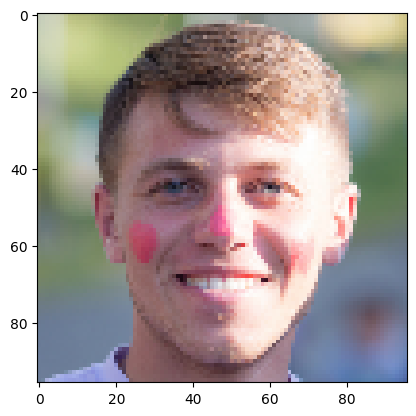

In [ ]:
plt.imshow(image)

## Dataset

In [ ]:
from torch.utils.data import Dataset, DataLoader

        # Library has entires in the form of tuples
        # Each tuple has the image path at the 0th index
        # and the label at the 1st

class FacialSentimentDataset(Dataset):
    def __init__(self, path, labelMap, transform):
        self.path = path
        self.images = []
        self.labels = []
        self.labelMap = labelMap
        self.transform = transform

        # Populate library with image paths and corresponding labels
        # Get each folder in the dataset
        for folder in os.listdir(path):
            # Skip labels file
            if folder == "labels.csv":
                continue
            # Get each image in each folder
            for image in os.listdir(path + folder):
                # Get image's corresponding label
                try:
                    label = df[df['pth'] ==  folder + '/' + image]['label'].item()
                    # self.library.append((folder + '/' + image,label))
                    self.images.append(folder + '/' + image)
                    self.labels.append(label)
                # Skip images that are not labeled
                except ValueError as e:
                    continue

    # Add get dataset's length function
    def __len__(self):
        return len(self.images)

    # Add get item at index from dataset
    def __getitem__(self,idx):
        # Get image path from library at an index
        imagePath = self.images[idx]
        # Open image with PIL
        image = Image.open(self.path + imagePath).convert("RGB")
        # Get label path from library at an index
        label = self.labels[idx]
        label = self.labelMap[label]

        # Apply given transform to each image
        if self.transform:
            image = self.transform(image)

        return image,label


dataset = FacialSentimentDataset(path + "/AffectNet Dataset/", labelMap, transform)

## Set Up Model

Load pre-trained ResNet & Libraries

In [ ]:
import torchvision.models as models
from torchvision.models import resnet152, ResNet152_Weights, resnet50, ResNet50_Weights, vgg19, VGG19_Weights
import pytorch_lightning as pl
from torchmetrics import Accuracy

# Load ResNet
# resnet152 = models.resnet152(pretrained=True)

In [ ]:
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR, CosineAnnealingLR, ReduceLROnPlateau
from torchmetrics.classification import MulticlassAccuracy

In [ ]:
class FacialSentimentAnalyser(pl.LightningModule):
    def __init__(self, num_classes):
        super(FacialSentimentAnalyser,self).__init__()

        # weights = ResNet50_Weights.DEFAULT
        # self.resnet = models.resnet50(weights=weights)

        weights = ResNet152_Weights.DEFAULT
        self.resnet = models.resnet152(weights=weights)
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, num_classes)

        # weights = VGG19_Weights.DEFAULT
        # self.vgg19 = models.vgg19(weights=weights)
        # self.vgg19.classifier[6] = nn.Linear(self.vgg19.classifier[6].in_features, num_classes)


        # self.learning_rate = 0.001
        self.learning_rate = 0.01
        self.loss = nn.CrossEntropyLoss()
        self.accuracy = Accuracy(num_classes=len(labelMap), task="multiclass").to("cuda")


    def forward(self, x):
        # return self.resnet(x)
        return self.vgg19(x)

    def configure_optimizers(self):

        optimizer = optim.SGD(self.parameters(), lr=0.001, momentum=0.9)
        scheduler = StepLR(optimizer, step_size=30, gamma=0.1)

        return [optimizer], [scheduler]

    def training_step(self, batch, batch_idx):
        image, label = batch
        logits = self(image)
        loss = self.loss(logits, label)
        acc = self.accuracy(logits, label)
        self.log('train_loss', loss, prog_bar=True)
        self.log('train_acc', acc, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        image, label = batch
        logits = self(image)
        loss = self.loss(logits, label)
        acc = self.accuracy(logits, label)
        self.log('val_loss', loss, prog_bar=True)
        self.log('val_acc', acc, prog_bar=True)
        return loss


    def test_step(self, batch, batch_idx):
        image, label = batch
        logits = self(image)
        loss = self.loss(logits, label)
        acc = self.accuracy(logits, label)
        self.log('test_loss', loss, prog_bar=True)
        self.log('test_acc', acc, prog_bar=True)

## Train

Split Dataset

In [ ]:
from torch.utils.data import Subset
from torch.utils.data import random_split

trainDatasetSize = int(0.7*len(dataset))
validationDatasetSize = int(0.2*len(dataset))
testDatasetSize = len(dataset) - (trainDatasetSize + validationDatasetSize)

shuffled_indices = torch.randperm(len(dataset))

train_indices = shuffled_indices[:trainDatasetSize]
validation_indices = shuffled_indices[trainDatasetSize:trainDatasetSize+validationDatasetSize]
test_indices = shuffled_indices[trainDatasetSize+validationDatasetSize:]


# Trying to shuffle indices
trainDataset = Subset(dataset, train_indices)
validationDataset = Subset(dataset, validation_indices)
testDataset = Subset(dataset, test_indices)

In [ ]:
len(trainDataset)

19722

Set Up Dataloaders

In [ ]:
batchSize = 64

trainDataloader = DataLoader(trainDataset, batch_size=batchSize, shuffle=True, num_workers=2)
validationDataloader = DataLoader(validationDataset, batch_size=batchSize, num_workers=2)
testDataloader = DataLoader(testDataset, batch_size=batchSize, num_workers=2)

In [ ]:
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import TensorBoardLogger


numEpochs = 6

model = FacialSentimentAnalyser(len(labelMap))

logger = TensorBoardLogger("/content/newlogs/resnet152_1", name="resnet152_logs_1")
trainer = Trainer(accelerator="gpu", devices="auto", max_epochs=numEpochs, logger=logger)

Downloading: "https://download.pytorch.org/models/resnet152-f82ba261.pth" to /root/.cache/torch/hub/checkpoints/resnet152-f82ba261.pth
100%|██████████| 230M/230M [00:01<00:00, 151MB/s]
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
trainer.fit(model, trainDataloader, validationDataloader)
# trainer.fit(model, trainDataloader)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name     | Type               | Params
------------------------------------------------
0 | vgg19    | VGG                | 139 M 
1 | loss     | CrossEntropyLoss   | 0     
2 | accuracy | MulticlassAccuracy | 0     
------------------------------------------------
139 M     Trainable params
0         Non-trainable params
139 M     Total params
558.412   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=6` reached.


In [ ]:
metrics = trainer.logged_metrics
print(metrics)


## Test

In [ ]:
# model.load_state_dict(torch.load("/content/gdrive/My Drive/ML/final-project/AffectNet Dataset/resnet152-good-metrics"))

In [ ]:
trainer.test(model,testDataloader)

## Inference

In [ ]:
model.eval()

imageRootPath = "/AffectNet Dataset/"
imageFilePath = "happy/ffhq_31.png"
image = Image.open(path + imageRootPath + imageFilePath)
image = transform(image).unsqueeze(0)
logits = model(image)
predictions = torch.argmax(logits, dim=1)

res = intToLabelMap[predictions.item()]
expected = df[df["pth"] == imageFilePath]['label'].item()
print(res)
print(expected)

res == expected


disgust
disgust


True

In [ ]:
# Save Logs
import shutil
import datetime
import os

local_log_path = '/content/lightning_logs'
for version_folder in os.listdir(local_log_path):
    timestamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

    local_version_path = os.path.join(local_log_path, version_folder)


    drive_version_path = os.path.join("/content/gdrive/My Drive/ML/final-project/AffectNet Dataset/AffectNetDataset"+"/logs/new/vgg-good", version_folder + "_" + timestamp)
    os.makedirs(drive_version_path, exist_ok=True)

    # Copy each version folder
    shutil.copytree(local_version_path, drive_version_path, dirs_exist_ok=True)

In [ ]:
torch.save(model.state_dict(), "/content/gdrive/My Drive/ML/final-project/AffectNet Dataset/" + "vgg-good")

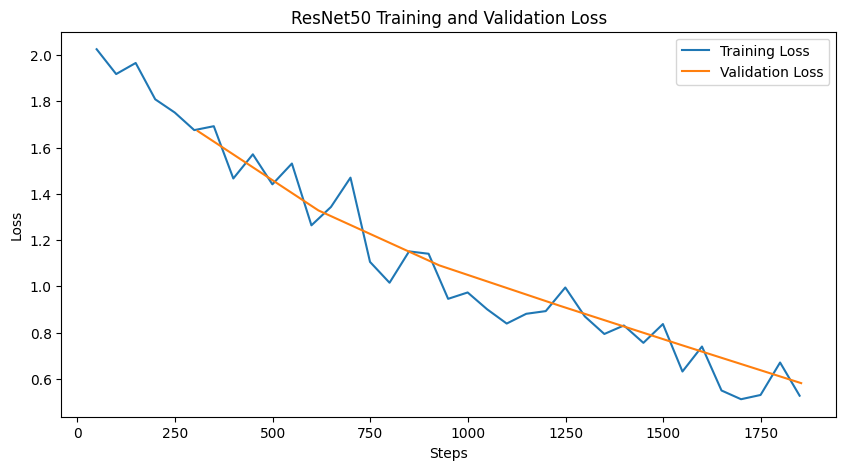

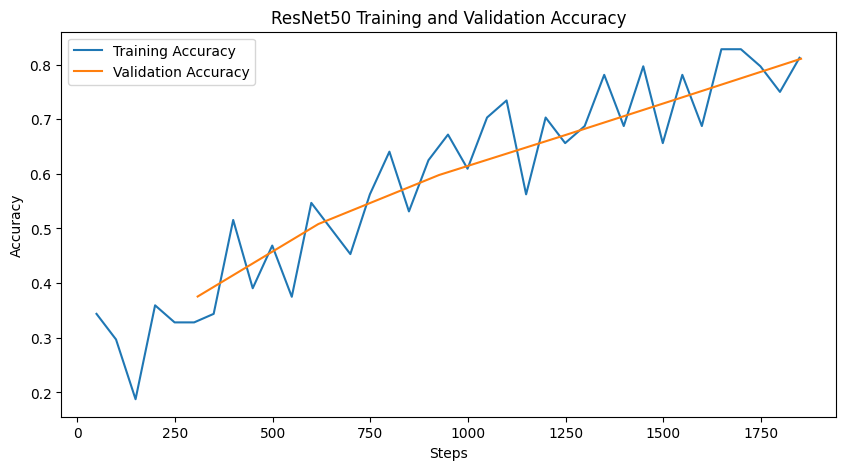

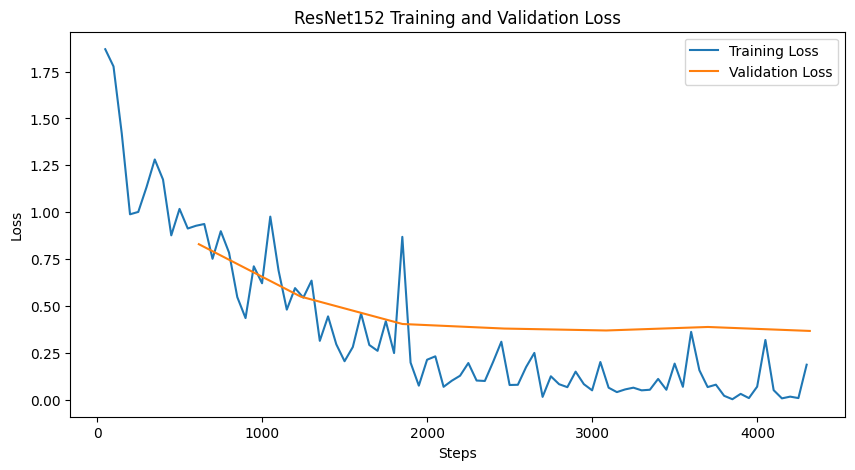

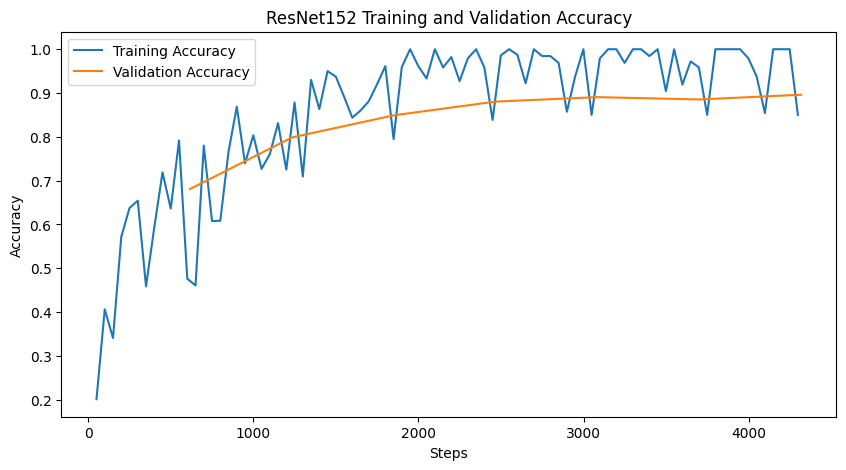

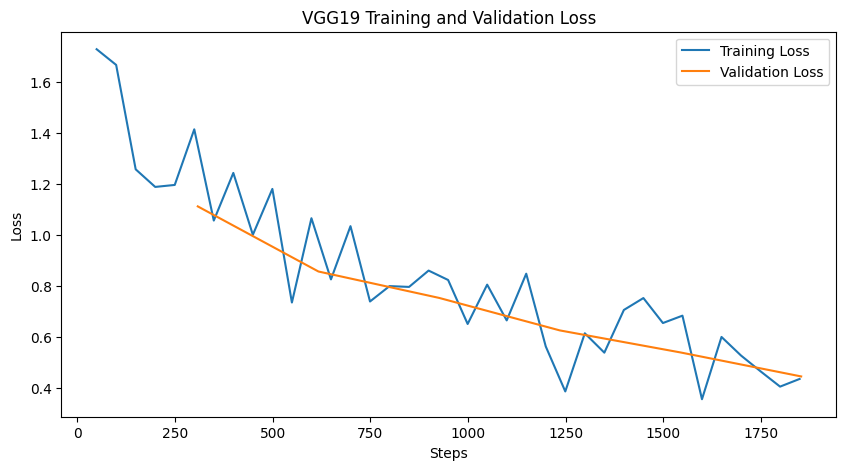

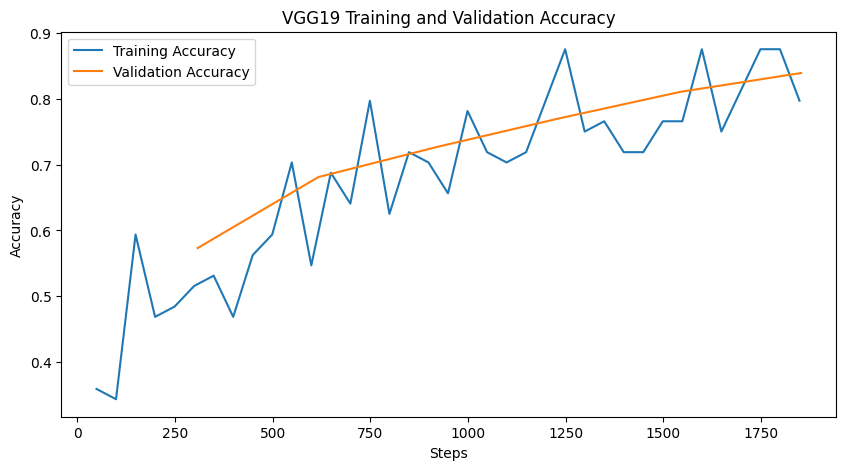

In [ ]:
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import matplotlib.pyplot as plt
import numpy as np

logdir = '/content/newlogs/resnet50/resnet50_logs/version_1'


def visualizeMetrics(path, modelName):

  event_acc = EventAccumulator(path)
  event_acc.Reload()

  # print(event_acc.Tags()['scalars'])

  # Extracting scalar data

  if modelName == "ResNet152":
    train_loss = event_acc.Scalars('train_loss_step')
    train_acc = event_acc.Scalars('train_acc_step')
    val_loss = event_acc.Scalars('validation_loss')
    val_acc = event_acc.Scalars('validation_acc')
  else:
    train_loss = event_acc.Scalars('train_loss')
    train_acc = event_acc.Scalars('train_acc')
    val_loss = event_acc.Scalars('val_loss')
    val_acc = event_acc.Scalars('val_acc')

  # Converting to numpy for plotting
  train_loss_steps = np.array([s.step for s in train_loss])
  train_loss_values = np.array([s.value for s in train_loss])
  train_acc_steps = np.array([s.step for s in train_acc])
  train_acc_values = np.array([s.value for s in train_acc])

  val_loss_steps = np.array([s.step for s in val_loss])
  val_loss_values = np.array([s.value for s in val_loss])
  val_acc_steps = np.array([s.step for s in val_acc])
  val_acc_values = np.array([s.value for s in val_acc])

  # Plotting the training and validation loss
  plt.figure(figsize=(10, 5))
  plt.plot(train_loss_steps, train_loss_values, label='Training Loss')
  plt.plot(val_loss_steps, val_loss_values, label='Validation Loss')
  plt.xlabel('Steps')
  plt.ylabel('Loss')
  plt.title(modelName + ' Training and Validation Loss')
  plt.legend()
  plt.show()

  # Plotting the training and validation accuracy
  plt.figure(figsize=(10, 5))
  plt.plot(train_acc_steps, train_acc_values, label='Training Accuracy')
  plt.plot(val_acc_steps, val_acc_values, label='Validation Accuracy')
  plt.xlabel('Steps')
  plt.ylabel('Accuracy')
  plt.title(modelName + ' Training and Validation Accuracy')
  plt.legend()
  plt.show()

path = '/content/gdrive/MyDrive/ML/final-project/final_logs/resnet50/resnet50_logs/version_1'
visualizeMetrics(path, "ResNet50")
path = '/content/gdrive/MyDrive/ML/final-project/final_logs/resnet152/resnet152_logs/version_9'
visualizeMetrics(path, "ResNet152")
path = '/content/gdrive/MyDrive/ML/final-project/final_logs/vgg19/vgg19_logs/version_1'
visualizeMetrics(path, "VGG19")


In [ ]:
# !cp -r "/content/newlogs" "/content/gdrive/MyDrive/ML/final-project/final_logs"